# Streamlined Dating Profiles
## Prioritized Questions

People looking for dating partners parse a burdensome volume of information, and much of that information fails to usefully distinguish one profile from the next. Dating profiles routinely include answers to hundreds, sometimes thousands, of questions about each person. Most of that information is necessarily redundant, in purely quantitative terms.

This notebook focuses on prioritizing the original dating profile questions. Other notebooks deal with data wrangling, factor analysis, and clustering.

In [1]:
import functools as fn
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import sklearn.decomposition as dc
import umap

import entropy as ent
import parametersearch as ps
import score as sc
import unsupervisedcv as ucv
import utility as utl
import visualization as viz

%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
# notebook-wide presets
MINUTE = 60
MISSING_IND = -1
N_JOBS = -1
N_ITER = 100
TIME_BOUND = 60 * MINUTE

# functions sensitive to missing values
entropy = fn.partial(ent.entropy, missing_ind=MISSING_IND)
info_variation = fn.partial(ent.info_variation, missing_ind=MISSING_IND)

# resource-bounded functions
parameter_search = fn.partial(
    ps.condensing_search,
    n_iter=N_ITER,
    max_time=TIME_BOUND,
    print_iter=True,
    tol=0.001
)
pdist = fn.partial(utl.pdist, n_jobs=N_JOBS)

## Data Set

OKCupid is a particularly promising data source because most of the profile questions are user-created, resulting in a larger and more diverse feature space than is economical to produce otherwise. In particular, there are less likely to be any blind spots where the questions fail to capture important information for distinguishing match quality. However, there are many problems to keep in mind:

- Many profile questions may be irrelevant.
- Users self-report their answers, making the data subject to dishonesty and lack of personal awareness.
- Users are free to withold answers to any question they choose, or stop answering after as few questions as they choose.
- The data set suffers a bias from users self-selecting into the dating website.
- The particular data set I'm analyzing has a strong selection bias in favor of profiles with at least 1,000 publicly answered questions—unusually thorough users.

[Chris McKinlay famously performed a superficially similar analysis to guide his own dating efforts](https://www.wired.com/2014/01/how-to-hack-okcupid/). [Other](https://doi.org/10.26775/ODP.2016.11.03) [researchers](https://github.com/rudeboybert/JSE_OkCupid) gathered similar data sets by the same method of scraping data from OKCupid and shared the data publicly. I will work with [The OKCupid dataset: A very large public dataset of dating site users](https://doi.org/10.26775/ODP.2016.11.03). OKCupid asks users to select which responses to each question they'd like from dating partners; but this data set unfortunately does not include that information, so I can't use those preferences to analyze what users are looking for. This also means I am limited to efficiently distinguishing one profile from the next. I can't filter based on what might make a better or worse match with this data.

In [3]:
# load profile data
# raw data was pre-processed in a separate notebook: Data Wrangling.ipynb
profiles = pd.read_feather('../processed_data/profiles.feather')

n_profiles = len(profiles)
features = [x for x in profiles.columns if x != 'missing_count']
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68371 entries, 0 to 68370
Columns: 2595 entries, q2 to missing_count
dtypes: int64(1), int8(2594)
memory usage: 169.7 MB


In [4]:
# load questions metadata
question_columns = [
    'qid',
    'text',
    'option_1',
    'option_2',
    'option_3',
    'option_4',
]
questions = pd.read_csv(
    '../source_data/okcupid_2015/question_data.csv',
    delimiter=';',
    names=question_columns,
    header=0,
    usecols=np.arange(6),
    index_col='qid',
)

### Missing Values

In [5]:
# check missing values in columns
missing_rate = profiles.apply(lambda x: x == MISSING_IND).mean()

n_cols_missing_half = np.sum(missing_rate > 0.5)
p_cols_missing_half = n_cols_missing_half / len(missing_rate)
print(
    f'{n_cols_missing_half} columns ({p_cols_missing_half:.0%}) are empty in more than half the rows.'
)
print(f'{missing_rate.mean():.0%} of all cells are empty.')

2382 columns (92%) are empty in more than half the rows.
76% of all cells are empty.


In [6]:
# check for rows with less than half missing values
n_rows_missing_half = np.sum(profiles['missing_count'] > (len(features) * 0.5))
p_rows_missing_half = n_rows_missing_half / n_profiles
print(
    f'{n_rows_missing_half} rows ({p_rows_missing_half:.0%}) are empty in more than half the columns.'
)

58579 rows (86%) are empty in more than half the columns.


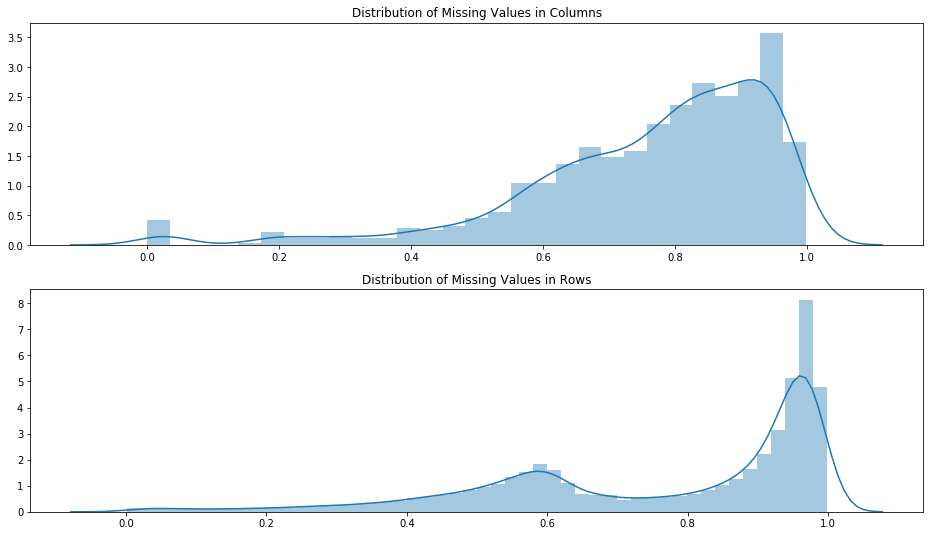

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(16, 9))

sns.distplot(missing_rate, ax=ax[0])
ax[0].set_title('Distribution of Missing Values in Columns')

sns.distplot((profiles['missing_count'] / len(features)).values)
ax[1].set_title('Distribution of Missing Values in Rows')

plt.show()

In [8]:
# check what the most-answered questions are
questions['missing_rate'] = missing_rate
questions.sort_values('missing_rate')[['text', 'missing_rate']].head(10)

,text,missing_rate
qid,,
q64664,Do you think it is okay to open old graves to ...,0.000000
q34113,How do you feel about government-subsidized fo...,0.000000
q85419,Which type of wine would you prefer to drink o...,0.000000
q20062,While in the middle of the best lovemaking of ...,0.000000
q416235,Do you like watching foreign movies with subti...,0.000000
lf_location,Location of match,0.029340
d_relationship,Relationship,0.029340
q16053,How willing are you to meet someone from OkCup...,0.151058
q501,Have you smoked a cigarette in the last 6 months?,0.164514


This dataset is dominated by missing values:

- 76% of all cells are empty.
- 91% of columns are empty for more than half the profiles.
- 5 columns—not 5%, just 5—have no missing values.
- 85% of profiles are empty in more than half the columns.

The values are missing not-at-random (MNAR):

- Users each answer different numbers of questions.
- OKCupid prioritizes some questions over others through the order they are presented to users.
- Users can choose to not answer any particular question, or to hide their response.

Treating this many missing values in each variable as a distinct informative class will likely grossly distort similarities between users. Imputation would be problematic with data MNAR and with the volume of missing data. It will be more appropriate to use methods that embrace missing values as an absence of information.

Scikit-Learn and the ecosystem of tools surrounding it reject missing values coded as `np.nan`, even when using a custom metric that accepts missing values. There are two ways to cope with this:

- For categorical data, `-1` as a missing value indicator survives the filter. The all-integer encoding is more compact in memory and on disk than the `float` columns that are necessary to accomodate `np.nan`.

- Many models accept precomputed distance matrices as input to fit. Constructing a distance matrix consumes a lot of time and memory ($O(n^2)$ for both), but models using a distance matrix also fit to the data much faster—all distance calculations are reduced to matrix look-ups.

Since model fitting is a larger time cost during (hyper)parameter tuning with direct search methods (including grid and random searches), I use the distance matrix approach whenever memory is not my binding constraint. For deployment, I would use the `-1`-coded input data instead for final models so they could be applied beyond the data used to fit the models, but that's not necessary for this proof of concept.

### Treating Ordinal Variables As Nominal

The questions include nominal and ordinal responses. For several reasons, I choose to treat all features as nominal data.

- Using the orderings would require 3 different correlations—one for each of nominal-nominal, nominal-ordinal, and ordinal-ordinal—which would be problematic to compare.
- With at most 4 possible responses to each profile question, the orderings don't add much, especially when using information-theoretic similarity measures.
- Treating all questions as nominal spares me some data wrangling work correcting types in the metadata (e.g., yes-or-no questions are incorrectly marked as ordinal).
- Witholding ordinal information from modeling creates a heuristic for distinguishing meaningful patterns from overfitting: When a model independently reconstructs original ordinal patterns, that's a good sign.

The data set also includes several variables that are not answers to the same framework of structured questions.

- 50 variables are profile factors derived by OKCupid to help summarize responses to the questions. I hope to arrive at a different, smaller combination of factors; so I will not be using these.
- 23 variables report conventional demographic information and dating intentions.
- 6 variables are criteria to filter what each user is "looking for" in prospective matches.

`d_username` obviously does not help group similar profiles, so I ignore it. `d_city` is omitted from the data by the source to protect users' privacy.

`d_age`, `lf_max_age`, and `lf_min_age` are ratio variables, and therefore not suitable for comparison using the same metric as for pairs of categorical variables. `d_income` seemed like it might also be a continuous ratio variable, but is actually discretized into 13 classes, so I include it.

`d_ethnicity`, `d_gender`, `d_languages`, `d_orientation`, and `lf_for` allow users to select multiple values, so I break those out into dummy features.

Data wrangling code is in a separate notebook (Data Wrangling.ipynb) to keep this one more focused.

In [9]:
# folds are used to create smaller samples that are faster to work with
# seed specified so folds are the same across notebooks in the project
randy = np.random.default_rng(733616026)

n_folds = 10
fold_masks = ucv.kfolds_masks(n_profiles, n_folds, rng=randy)

## Most Distinguishing Features

Supposing that I could only organize the data based on the existing variables without deriving any new features, I want to prioritize the variables most effective at discriminating between profiles—features with the highest [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)).

The existing popular functions for calculating entropy do not handle missing values well. I created new entropy functions that appropriately use missing values to discount the information value of variables. I demonstrate and compare the different implementations of entropy in a separate notebook (Entropy With Missing Values.ipynb).

I also want to minimize how much the best-ranked features correlate with each other. I do this with a heuristic procedure of selecting top features based on a combination of entropy and lack of correlation with other top features, vaguely similar to how decision trees are constructed. I use [variation of information](https://en.wikipedia.org/wiki/Variation_of_information) for comparing features. Sticking with an information-theoretic metric is consistent with the spirit of using entropy for feature strength.

In [10]:
# select fold for feature selection exploration
X = profiles[fold_masks[0]][features]

# prioritize features by entropy
f_entropy = entropy(X)
best_entropy_features = f_entropy.sort_values(ascending=False).index.tolist()
X = X[best_entropy_features]

In [11]:
# see what some of the best features are based on entropy alone
questions['entropy'] = [
    f_entropy[qid] if qid in features else np.nan for qid in questions.index
]
questions.sort_values('entropy', ascending=False).head(33)

,text,option_1,option_2,option_3,option_4,missing_rate,entropy
qid,,,,,,,
d_job,Job,NaN,NaN,NaN,NaN,0.260432,2.900932
d_astrology_sign,Astrology sign,NaN,NaN,NaN,NaN,0.277428,2.590623
d_bodytype,Body type,NaN,NaN,NaN,NaN,0.197072,2.299700
d_religion_type,Religion type,NaN,NaN,NaN,NaN,0.388674,1.619144
q34113,How do you feel about government-subsidized fo...,No problem,"It's okay, if it is not abused",Okay for short amounts of time,Never - Get a job,0.000000,1.615024
d_education_type,Education type,NaN,NaN,NaN,NaN,0.255196,1.536572
q41,How important is religion/God in your life?,Extremely important,Somewhat important,Not very important,Not at all important,0.208144,1.420829
q997,Are you a cat person or a dog person?,Cats,Dogs,Both,Neither,0.199280,1.371916
q79,What's your relationship with marijuana?,I smoke regularly.,I smoke occasionally.,"I smoked in the past, but no longer.",Never.,0.271680,1.287568


In [12]:
# calculate feature distance matrix and dimensionality
f_dist_matrix, f_implied_dim, _ = utl.dist_matrix_and_dim(
    X.T, info_variation)

In [13]:
# re-order features using entropy & distance heuristic
def rank_features():
    # initial best feature
    entropy_rank = [n for n in range(len(f_dist_matrix))]  # already sorted
    remaining_i = entropy_rank
    mean_dist = np.mean(f_dist_matrix, axis=0)
    dist_rank = st.rankdata(mean_dist)  # prioritize features close to others
    total_rank = entropy_rank + dist_rank
    best_i = [remaining_i.pop(np.argmin(total_rank))]

    # re-order remaining features
    while len(remaining_i) > 1:
        # prioritize high-entropy features
        entropy_rank = np.array(
            [n for n in range(len(remaining_i))])  # already sorted

        # prioritize features far from the already-selected best
        dist_to_best = f_dist_matrix[best_i].T[remaining_i]
        min_dist_to_best = np.amin(dist_to_best, axis=1)
        # high distance -> low rank
        dist_best_rank = st.rankdata(-1 * min_dist_to_best)

        total_rank = entropy_rank + dist_best_rank
        best_i.append(remaining_i.pop(np.argmin(total_rank)))

    best_features = [best_entropy_features[i] for i in best_i]
    best_entropies = [f_entropy.loc[f] for f in best_features]
    return best_features, best_entropies


best_features, best_entropies = rank_features()

In [14]:
# show best features ordered by distance-aware ranking
q_best = [q for q in questions.index if q in best_features]
q_best = [bf for bf in best_features if bf in q_best]
questions.loc[q_best].head(33)

,text,option_1,option_2,option_3,option_4,missing_rate,entropy
qid,,,,,,,
d_job,Job,NaN,NaN,NaN,NaN,0.260432,2.900932
d_astrology_sign,Astrology sign,NaN,NaN,NaN,NaN,0.277428,2.590623
d_bodytype,Body type,NaN,NaN,NaN,NaN,0.197072,2.299700
d_religion_type,Religion type,NaN,NaN,NaN,NaN,0.388674,1.619144
q34113,How do you feel about government-subsidized fo...,No problem,"It's okay, if it is not abused",Okay for short amounts of time,Never - Get a job,0.000000,1.615024
d_education_type,Education type,NaN,NaN,NaN,NaN,0.255196,1.536572
q41,How important is religion/God in your life?,Extremely important,Somewhat important,Not very important,Not at all important,0.208144,1.420829
q997,Are you a cat person or a dog person?,Cats,Dogs,Both,Neither,0.199280,1.371916
q79,What's your relationship with marijuana?,I smoke regularly.,I smoke occasionally.,"I smoked in the past, but no longer.",Never.,0.271680,1.287568


Unsurprisingly, the selected features usually have many possible options. The demographic variables (`d_*`) have many more. This is typical of entropy-based feature selection. When there are more possible subdivisions, those subdivisions tend to be smaller, leading to higher potential entropy. It also tends to increase the variational information (distance) between any already-selected features with fewer categories.

Interestingly, gender and orientation are not included in the features selected by this initial approach. These are important criteria for finding dating partners. This does not mean that the features don't strongly correlate with gender or orientation, only that they divide the data more efficiently.

I create a [UMAP](https://arxiv.org/abs/1802.03426) embedding of the features to visually inspect the effect of this ranking procedure, and to check if there is any additional structure to exploit for feature selection.

In [15]:
# functions to support tuning embedding parameters
def display_format_params(param_dict):
    """Formats a parameter dictionary for display in-line in text"""
    values = [
        f"{name}={value_text_format(value)}"
        for name, value in zip(param_dict.keys(), param_dict.values())
    ]
    return "(" + ", ".join(values) + ")"


def score_func(dist_matrix):
    def score(**kwargs):
        scores = ucv.embedding_cross_val(
            sc.embedding_matrix_score,
            lambda data: umap_pca(data, metric='precomputed', **kwargs),
            dist_matrix,
            dist_matrix_data=True,
        )
        return np.mean(scores)
    return score


def umap_param_specs(implied_dim, n, plot_only=False):
    min_dim = 2
    min_neighbors = utl.iceil(implied_dim) + 1  # simplex
    max_dim = min(min_neighbors, utl.max_entropy_dimension(n))
    max_neighbors = n // max_dim

    if plot_only:
        n_components = ps.param_spec_constant(2)
    else:
        n_components = ps.param_spec_int([min_dim, max_dim])
    return {
        'n_components': n_components,
        'n_neighbors': ps.param_spec_int([min_neighbors, max_neighbors]),
        'min_dist': ps.param_spec_float([0.01, 0.99]),
    }


def umap_pca(data, **umap_args):
    """UMAP embedding followed by PCA re-orientation"""
    umap_model = umap.UMAP(**umap_args)
    umap_features = umap_model.fit_transform(data)
    return dc.PCA().fit_transform(umap_features)


def value_text_format(value):
    if isinstance(value, float):
        return f"{value:.3f}"
    else:
        return value

In [16]:
# parameter search for feature visualization embedding
f_umap_params, f_umap_score = parameter_search(
    umap_param_specs(f_implied_dim, len(f_dist_matrix), plot_only=True), score_func(f_dist_matrix))

print(
    f'Best score: {f_umap_score:.3f}, Parameters: {display_format_params(f_umap_params)}')


f_plot = umap_pca(f_dist_matrix, metric='precomputed', **f_umap_params).T

Condensing search iterations: 100
Best score: 0.272, Parameters: (n_components=2, n_neighbors=119, min_dist=0.662)


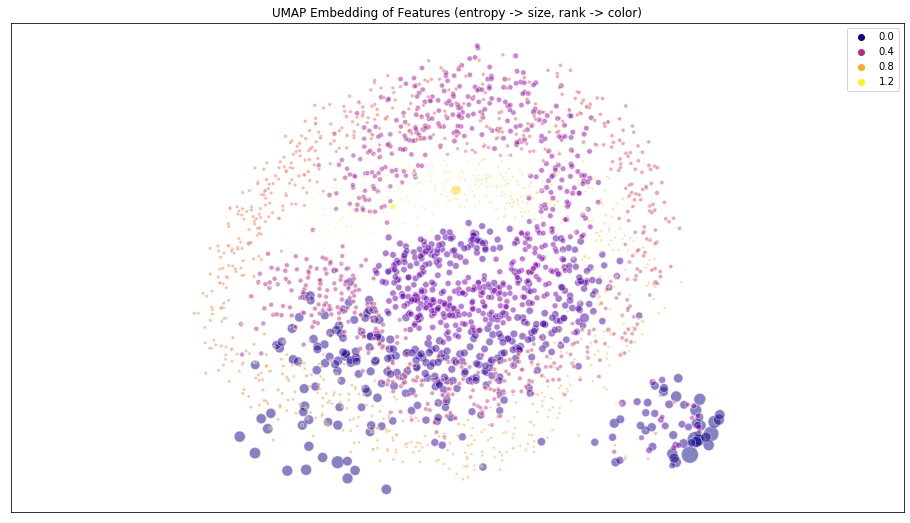

In [17]:
# plot UMAP embedding of features
n = len(f_dist_matrix)
rank = [i / n for i in range(n)]

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.scatterplot(
    *f_plot,
    s=np.array(best_entropies[:n]) * 100,  # entropy -> size
    hue=rank,
    alpha=0.5,
    ax=ax,
    palette='plasma',
)
viz.hide_ticks_square(ax)
plt.title(f'UMAP Embedding of Features (entropy -> size, rank -> color)')
plt.show()

Visual inspection of the embedding suggests that the variables do not cleanly separate into distinct clusters that might represent statistically independent latent factors. (Variables with low correlation will have high variation of information, and will tend to be far from each other in the embedding.) Since there are far more profiles than variables, the apparent dimension of the variable space could potentially be large enough to make inter-variable distances homogenous, consistent with the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). So it's no surprise that the embedding is a more-or-less uniform disc, or that the relative positions of variables with more and less entropy (larger and smaller dots, respectively) are unstable between embeddings with different random initializations. This does not necessarily mean that there are no useful latent factors to extract, only that this is not an effective method for finding them.